In [7]:
import os
import h5py
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [8]:
filename = '/Users/a1/Desktop/project/pytorch_practice/data/N-CMAPSS_DS02-006.h5'

In [9]:
# Time tracking, Operation time (min):  0.003
t = time.process_time()  

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.0073310999999999975

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [10]:
print("dev_engines:", np.unique(A_dev[:, 0]))
print("test_engines:",np.unique(A_test[:, 0]))

dev_engines: [ 2.  5. 10. 16. 18. 20.]
test_engines: [11. 14. 15.]


In [68]:
# 입력
eng = A_dev[:, 0].astype(int)
state = A_dev[:, 3].astype(int)

normal_ranges = []
abnormal_ranges = []

start = 0

for i in range(1, len(state)):
    # 구간 종료 조건:
    # 1) state 변화
    # 2) 엔진 변화
    if (state[i] != state[i - 1]) or (eng[i] != eng[i - 1]):
        end = i - 1
        if state[start] == 1:
            normal_ranges.append((start, end))
        else:
            abnormal_ranges.append((start, end))
        start = i

# 마지막 구간 처리
end = len(state) - 1
if state[start] == 1:
    normal_ranges.append((start, end))
else:
    abnormal_ranges.append((start, end))

print("\n=== Range summary (A_dev index) ===")
print(f"Total normal ranges   : {len(normal_ranges)}")
print(f"Total abnormal ranges : {len(abnormal_ranges)}")

print("\nNormal ranges by engine:")
for (s, e) in normal_ranges:
    print(f"  Engine {eng[s]} : [{s}, {e}] (len={e - s + 1})")

print("\nAbnormal ranges by engine:")
for (s, e) in abnormal_ranges:
    print(f"  Engine {eng[s]} : [{s}, {e}] (len={e - s + 1})")


normal_engines   = [2, 5, 10]
abnormal_engines = [16, 18, 20]

K = 300  # 엔진별, 구간별 샘플 수

sampled_dev_idx_list = []

for eng_id in normal_engines:
    for (s, e) in normal_ranges:
        if eng[s] != eng_id:
            continue

        idx = np.arange(s, e + 1)
        T = len(idx)
        if T <= 0:
            continue

        k = min(K, T)
        pos = np.linspace(0, T - 1, num=k)
        pos = np.round(pos).astype(int)
        pos = np.unique(pos)

        if pos.size < k:
            pool = np.setdiff1d(np.arange(T), pos)
            need = k - pos.size
            add = np.round(np.linspace(0, pool.size - 1, num=need)).astype(int)
            pos = np.sort(np.concatenate([pos, pool[add]]))
        else:
            pos = np.sort(pos[:k])

        sampled_dev_idx_list.append(idx[pos])

sampled_dev_idx = np.sort(np.unique(np.concatenate(sampled_dev_idx_list)))

print("\n=== DEV sampling (normal state) ===")
print(f"Target engines : {normal_engines}")
print(f"Samples per range (K) : {K}")

dev_count_by_engine = {e: 0 for e in normal_engines}

for eng_id in normal_engines:
    for (s, e) in normal_ranges:
        if eng[s] != eng_id:
            continue

        T = e - s + 1
        k_used = min(K, T)
        dev_count_by_engine[eng_id] += k_used

        print(
            f"  Engine {eng_id} | range [{s},{e}] "
            f"| range_len={T} | sampled={k_used}"
        )

print("\nDEV sampled count by engine:")
for eng_id, cnt in dev_count_by_engine.items():
    print(f"  Engine {eng_id} : {cnt}")

print(f"\nTotal DEV sampled indices: {len(sampled_dev_idx)}")


sampled_test_idx_list = []

for eng_id in abnormal_engines:
    for (s, e) in abnormal_ranges:
        if eng[s] != eng_id:
            continue

        idx = np.arange(s, e + 1)
        T = len(idx)
        if T <= 0:
            continue

        k = min(K, T)
        pos = np.linspace(0, T - 1, num=k)
        pos = np.round(pos).astype(int)
        pos = np.unique(pos)

        if pos.size < k:
            pool = np.setdiff1d(np.arange(T), pos)
            need = k - pos.size
            add = np.round(np.linspace(0, pool.size - 1, num=need)).astype(int)
            pos = np.sort(np.concatenate([pos, pool[add]]))
        else:
            pos = np.sort(pos[:k])

        sampled_test_idx_list.append(idx[pos])

sampled_test_idx = np.sort(np.unique(np.concatenate(sampled_test_idx_list)))

print("\n=== TEST sampling (abnormal state) ===")
print(f"Target engines : {abnormal_engines}")
print(f"Samples per range (K) : {K}")

test_count_by_engine = {e: 0 for e in abnormal_engines}

for eng_id in abnormal_engines:
    for (s, e) in abnormal_ranges:
        if eng[s] != eng_id:
            continue

        T = e - s + 1
        k_used = min(K, T)
        test_count_by_engine[eng_id] += k_used

        print(
            f"  Engine {eng_id} | range [{s},{e}] "
            f"| range_len={T} | sampled={k_used}"
        )

print("\nTEST sampled count by engine:")
for eng_id, cnt in test_count_by_engine.items():
    print(f"  Engine {eng_id} : {cnt}")

print(f"\nTotal TEST sampled indices: {len(sampled_test_idx)}")



=== Range summary (A_dev index) ===
Total normal ranges   : 6
Total abnormal ranges : 6

Normal ranges by engine:
  Engine 2 : [0, 188862] (len=188863)
  Engine 5 : [853142, 1041691] (len=188550)
  Engine 10 : [1886562, 2074611] (len=188050)
  Engine 16 : [2839273, 3033891] (len=194619)
  Engine 18 : [3604568, 3797856] (len=193289)
  Engine 20 : [4495287, 4688640] (len=193354)

Abnormal ranges by engine:
  Engine 2 : [188863, 853141] (len=664279)
  Engine 5 : [1041692, 1886561] (len=844870)
  Engine 10 : [2074612, 2839272] (len=764661)
  Engine 16 : [3033892, 3604567] (len=570676)
  Engine 18 : [3797857, 4495286] (len=697430)
  Engine 20 : [4688641, 5263446] (len=574806)

=== DEV sampling (normal state) ===
Target engines : [2, 5, 10]
Samples per range (K) : 300
  Engine 2 | range [0,188862] | range_len=188863 | sampled=300
  Engine 5 | range [853142,1041691] | range_len=188550 | sampled=300
  Engine 10 | range [1886562,2074611] | range_len=188050 | sampled=300

DEV sampled count by e

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

selected_indices = [torch.tensor(sampled_dev_idx, device=device)]
selected_indices_test = [torch.tensor(sampled_test_idx, device=device)]

X_list = [torch.tensor(W_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
          for idx in selected_indices]
Y_list = [torch.tensor(X_s_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
          for idx in selected_indices]
x_test_list = [torch.tensor(W_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
               for idx in selected_indices_test]
y_test_list = [torch.tensor(X_s_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
               for idx in selected_indices_test]

X = torch.cat(X_list, dim=0)        # (N_dev, D)
Y = torch.cat(Y_list, dim=0)        # (N_dev, 14)
x_test = torch.cat(x_test_list, dim=0)   # (N_test, D)
y_test = torch.cat(y_test_list, dim=0)   # (N_test, 14)

x_mean = X.mean(dim=0)
x_var  = X.var(dim=0, unbiased=False)
x_std  = x_var.sqrt()
x_scaled = (X - x_mean) / x_std

y_mean = Y.mean(dim=0)              # (14,)
y_var  = Y.var(dim=0, unbiased=False)
y_std  = y_var.sqrt()               # (14,)
y_scaled = (Y - y_mean) / y_std     # (N_dev, 14)

[INFO] common sampled_idx len = 900

=== [0] T24 ===
[Value]
MAE  : 0.0119
RMSE : 0.0164
R²   : 0.9997

=== [1] T30 ===
[Value]
MAE  : 0.0171
RMSE : 0.0235
R²   : 0.9995

=== [2] T48 ===
[Value]
MAE  : 0.1015
RMSE : 0.1371
R²   : 0.9813

=== [3] T50 ===
[Value]
MAE  : 0.1754
RMSE : 0.2396
R²   : 0.9448

=== [4] P15 ===
[Value]
MAE  : 0.0027
RMSE : 0.0034
R²   : 1.0000

=== [5] P2 ===
[Value]
MAE  : 0.0015
RMSE : 0.0027
R²   : 1.0000

=== [6] P21 ===
[Value]
MAE  : 0.0027
RMSE : 0.0034
R²   : 1.0000

=== [7] P24 ===
[Value]
MAE  : 0.0055
RMSE : 0.0073
R²   : 0.9999

=== [8] Ps30 ===
[Value]
MAE  : 0.0117
RMSE : 0.0161
R²   : 0.9997

=== [9] P40 ===
[Value]
MAE  : 0.0116
RMSE : 0.0161
R²   : 0.9997

=== [10] P50 ===
[Value]
MAE  : 0.0055
RMSE : 0.0083
R²   : 0.9999

=== [11] Nf ===
[Value]
MAE  : 0.0099
RMSE : 0.0125
R²   : 0.9998

=== [12] Nc ===
[Value]
MAE  : 0.0235
RMSE : 0.0354
R²   : 0.9987

=== [13] Wf ===
[Value]
MAE  : 0.0313
RMSE : 0.0440
R²   : 0.9981


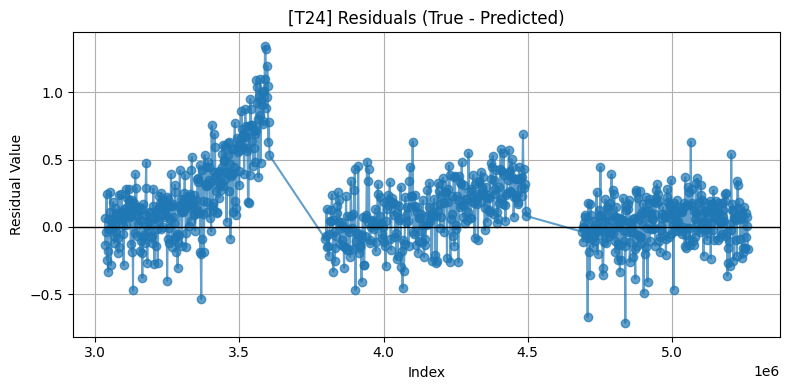

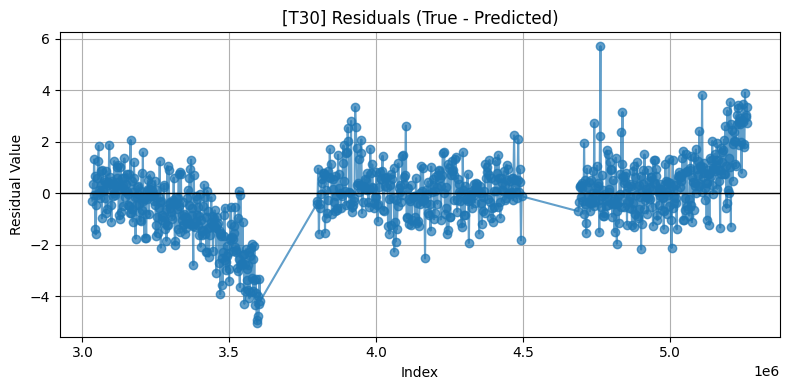

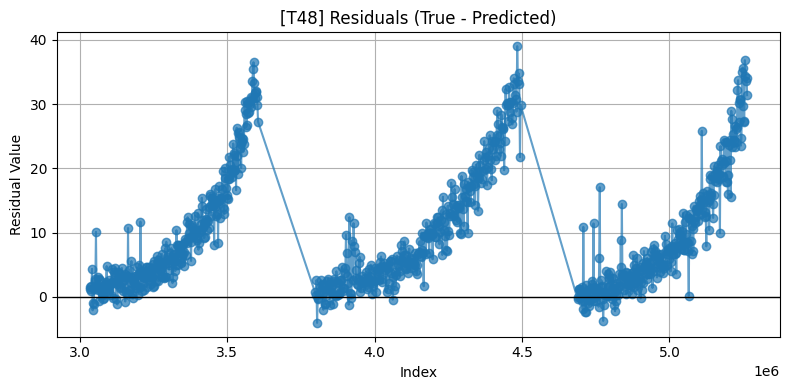

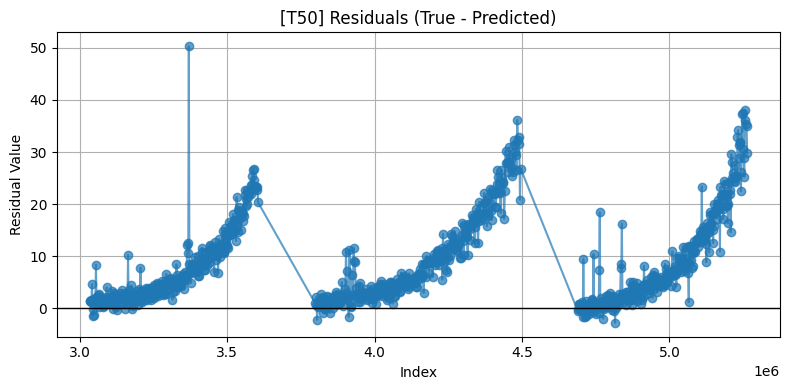

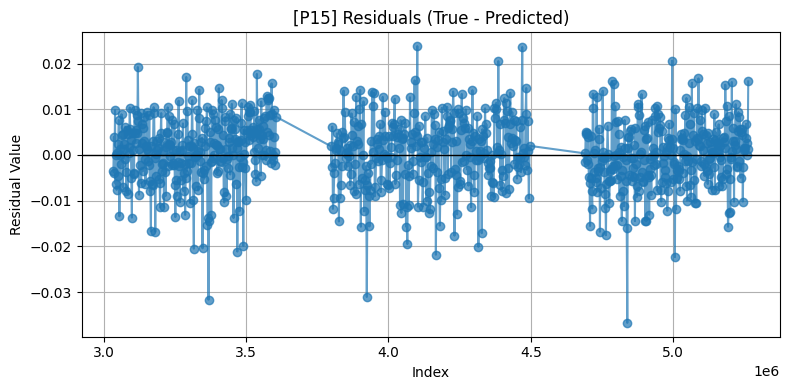

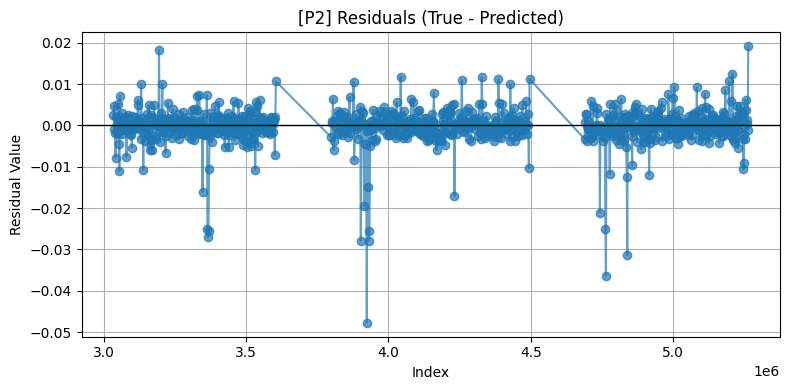

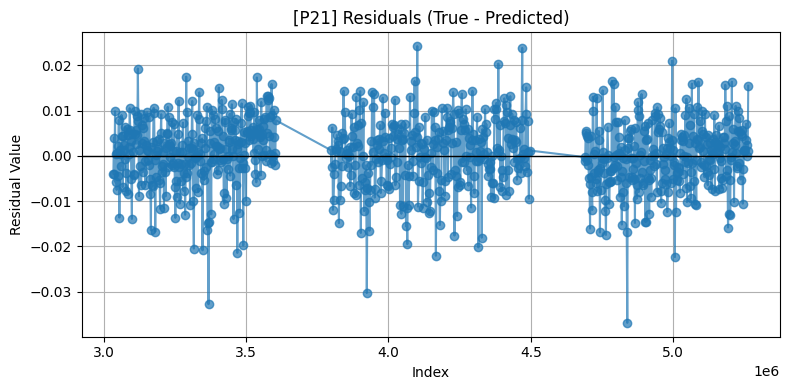

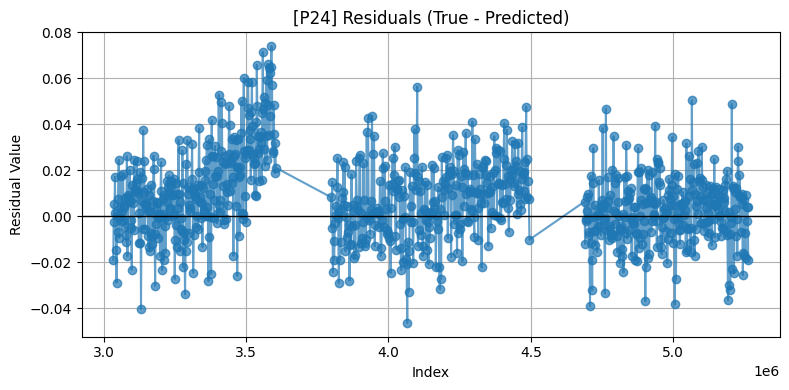

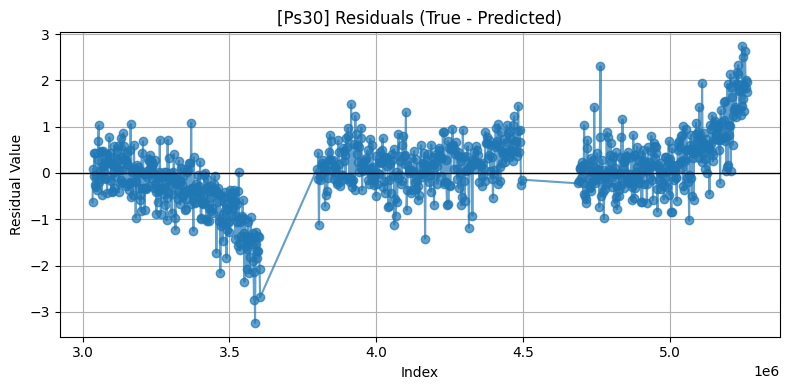

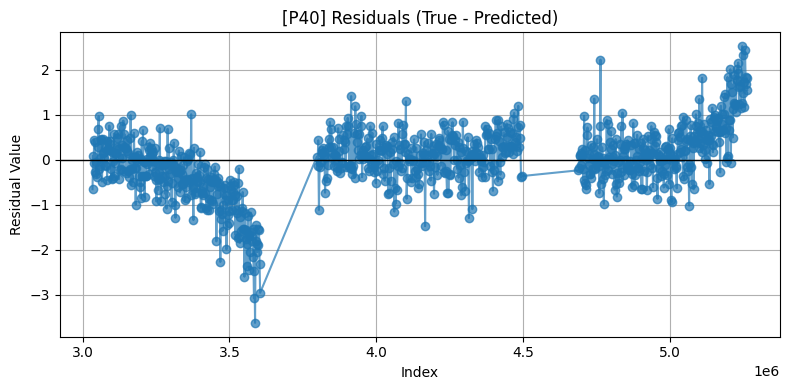

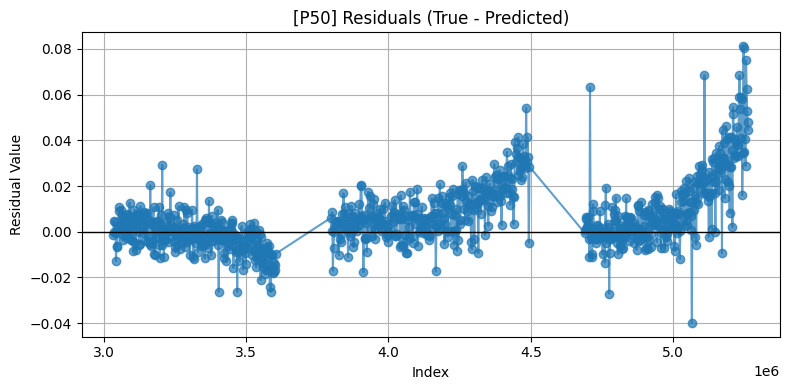

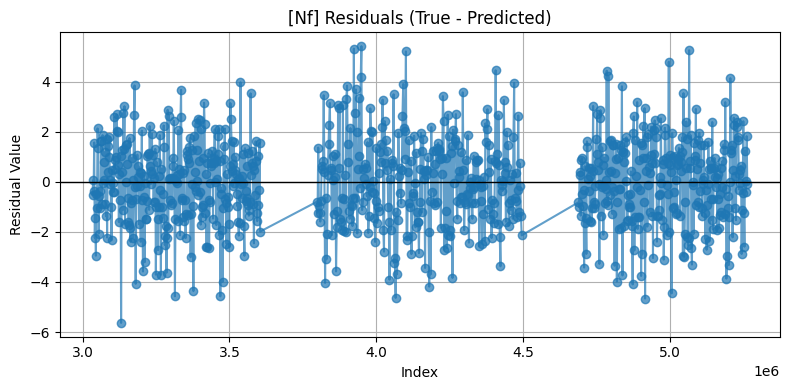

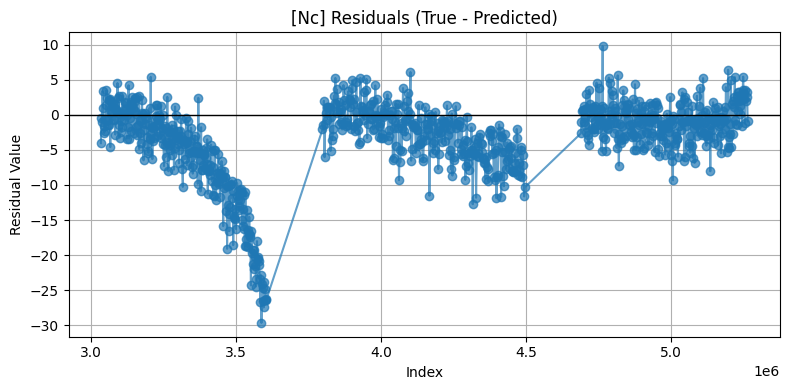

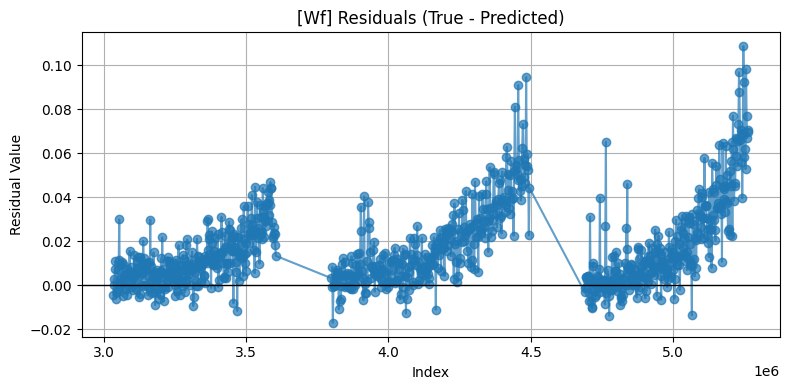

In [65]:
import gpytorch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

output_names = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24',
                'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']

# 0) 잔차 저장용
all_residuals = []
high_r2_list = []
total_all_idx = sampled_test_idx

sampled_idx = sampled_test_idx
# N_sel = min(N, len(total_all_idx))
# sampled_idx = np.random.choice(total_all_idx, size=N_sel, replace=False)
# sampled_idx.sort()
print(f"[INFO] common sampled_idx len = {len(sampled_idx)}")

# =========================================================
# 1) 다출력 GP 모델 정의
# =========================================================
num_tasks = Y.shape[1]   # 14

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # 각 task별 상수 평균 + multitask 구조
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        # 입력 커널(RBF) × task 간 공분산(coregionalization)
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(),
            num_tasks=num_tasks,
            rank=2,   # task 공분산 rank (필요시 조정)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)       # (N, num_tasks)
        covar_x = self.covar_module(x)     # Multitask 커널
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# 학습 데이터
train_x = x_scaled.to(device)      # (N_dev, D)
train_y = y_scaled.to(device)      # (N_dev, 14)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
    num_tasks=num_tasks
).to(device)

model = MultitaskGPModel(train_x, train_y, likelihood).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# =========================================================
# 2) train (한 번만)
# =========================================================
model.train(); likelihood.train()
num_iters = 100
for i in range(num_iters):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    # 필요하면 loss 출력
    # if (i+1) % 10 == 0:
    #     print(f"Iter {i+1}/{num_iters}, loss={loss.item():.4f}")

# =========================================================
# 3) TEST 전체에 대한 다출력 예측 + 지표
# =========================================================
model.eval(); likelihood.eval()

x_test_scaled = (x_test - x_mean) / x_std
x_test_scaled = x_test_scaled.to(device)

y_test_scaled = (y_test - y_mean) / y_std     # (N_test, 14)
y_test_scaled_t = y_test_scaled.to(device)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(x_test_scaled))
    mean_all = preds.mean    # (N_test, 14)

# 출력별 지표 계산
for j, name in enumerate(output_names):
    y_true_j = y_test_scaled_t[:, j].cpu().numpy()
    y_pred_j = mean_all[:, j].cpu().numpy()

    mse  = mean_squared_error(y_true_j, y_pred_j)
    mae  = mean_absolute_error(y_true_j, y_pred_j)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true_j, y_pred_j)
    high_r2_list.append({
        "name": name,
        "r2": r2,
    })

    print(f"\n=== [{j}] {name} ===")
    print(f"[Value]")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")

# =========================================================
# 4) 공통 인덱스(sampled_idx)에서 잔차 (실제 - 예측) 저장
# =========================================================
# 4-1) 공통 인덱스의 입력
x_sel = torch.tensor(W_dev[sampled_idx], dtype=torch.float32, device=device)
x_sel_scaled = (x_sel - x_mean) / x_std

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_sel = likelihood(model(x_sel_scaled))
    mean_sel_all = preds_sel.mean          # (N_sel, 14)

# 4-2) 출력별 잔차 계산 (언스케일)
for j, name in enumerate(output_names):
    # 실제값 (원 스케일)
    y_true_unscaled = torch.tensor(
        X_s_dev[sampled_idx, j],
        dtype=torch.float32,
        device=device
    )

    # 예측값 (원 스케일로 되돌리기)
    y_pred_unscaled = mean_sel_all[:, j] * y_std[j] + y_mean[j]

    residual = (y_true_unscaled - y_pred_unscaled).detach().cpu().numpy()

    all_residuals.append({
        "name": name,
        "idx": sampled_idx.copy(),
        "residual": residual.copy(),
    })
    # print(f"[STORE] {name} residual saved. N={len(residual)}")
    plt.figure(figsize=(8,4))
    plt.plot(sampled_idx, residual, marker='o', linestyle='-', alpha=0.7)
    plt.axhline(0, color='black', linewidth=1)         # baseline
    plt.title(f"[{name}] Residuals (True - Predicted)")
    plt.xlabel("Index")
    plt.ylabel("Residual Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [66]:
print("len(all_residuals) =", len(all_residuals))

# 각 변수별 residual/idx 길이 확인
for i, d in enumerate(all_residuals):
    print(f"[{i:02d}] {d['name']}: len(idx)={len(d['idx'])}, len(residual)={len(d['residual'])}")

# (선택) 길이가 서로 다른지 요약
lens = [len(d["residual"]) for d in all_residuals]
print("unique residual lengths =", sorted(set(lens)))

len(all_residuals) = 14
[00] T24: len(idx)=900, len(residual)=900
[01] T30: len(idx)=900, len(residual)=900
[02] T48: len(idx)=900, len(residual)=900
[03] T50: len(idx)=900, len(residual)=900
[04] P15: len(idx)=900, len(residual)=900
[05] P2: len(idx)=900, len(residual)=900
[06] P21: len(idx)=900, len(residual)=900
[07] P24: len(idx)=900, len(residual)=900
[08] Ps30: len(idx)=900, len(residual)=900
[09] P40: len(idx)=900, len(residual)=900
[10] P50: len(idx)=900, len(residual)=900
[11] Nf: len(idx)=900, len(residual)=900
[12] Nc: len(idx)=900, len(residual)=900
[13] Wf: len(idx)=900, len(residual)=900
unique residual lengths = [900]


In [75]:
signal_names = []
residual_matrix = []

for r in all_residuals:
    signal_names.append(r["name"])
    residual_matrix.append(r["residual"])

# shape: (num_signals, num_samples)
residual_matrix = np.vstack(residual_matrix)

corr_matrix = np.corrcoef(residual_matrix)

distance_matrix = 1 - np.abs(corr_matrix)

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

D_condensed = squareform(distance_matrix, checks=False)
Z = linkage(D_condensed, method="average")

rho_th = 0.75
dist_th = 1 - rho_th

clusters = fcluster(Z, t=dist_th, criterion="distance")

hi_feature_idx = []

for c in np.unique(clusters):
    idx = np.where(clusters == c)[0]
    hi_feature_idx.append(idx[0])   # 임의 선택 (첫 번째)

hi_var_names = [signal_names[i] for i in hi_feature_idx]
selected_residuals = residual_matrix[hi_feature_idx]
print(hi_var_names)

['T24', 'P15', 'Nf', 'T48', 'T30', 'P50', 'P2']


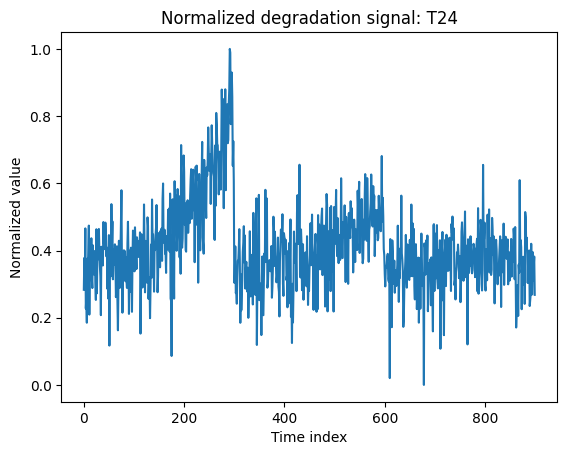

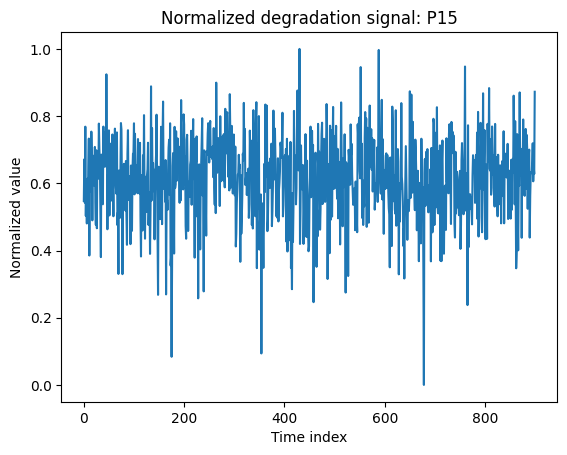

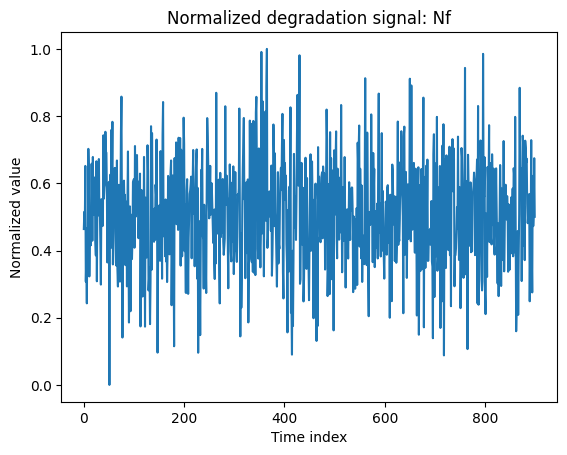

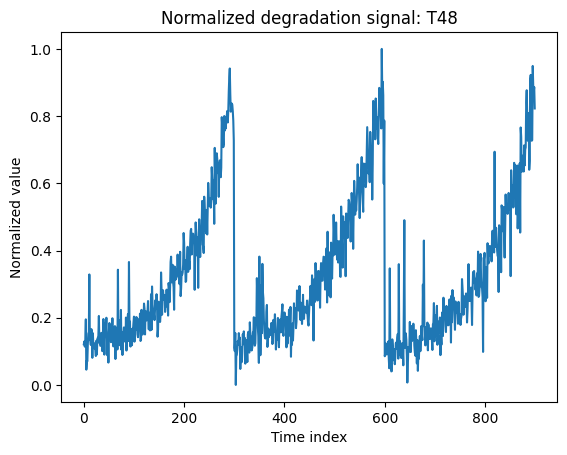

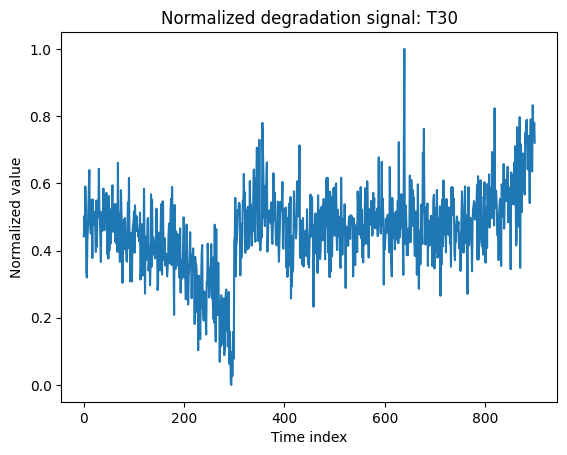

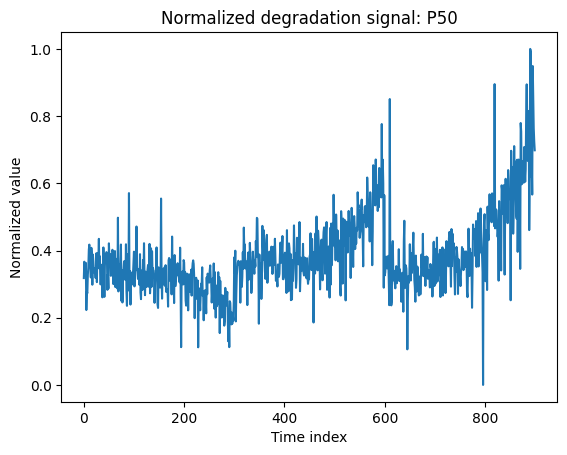

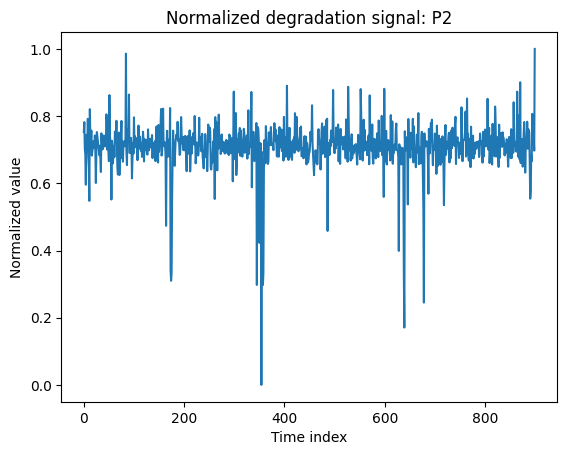

In [83]:
X = selected_residuals

X_min = X.min(axis=1, keepdims=True)
X_max = X.max(axis=1, keepdims=True)

X_norm = (X - X_min) / (X_max - X_min + 1e-8)

num_signals = X_norm.shape[0]
t = np.arange(X_norm.shape[1])

for i in range(num_signals):
    plt.figure()
    plt.plot(t, X_norm[i])
    plt.xlabel("Time index")
    plt.ylabel("Normalized value")
    plt.title(f"Normalized degradation signal: {hi_var_names[i]}")
    plt.show()


In [103]:
# tanh + linear

import torch
import torch.nn as nn

class HINet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 5)
        self.fc2 = nn.Linear(5, 3)
        self.out = nn.Linear(3, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        h = self.out(x)
        return h.squeeze(-1)



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

D = X_norm.shape[0]
K = 300
num_engines = 3

lambda0 = 5.0 
lambda1 = 2.1
lambda2 = 3.8
lr = 0.01
epochs = 400
eps = 1e-8

X_tensor = torch.tensor(X_norm.T, dtype=torch.float32).to(device)

net = HINet().to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)


In [125]:
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # ---------- Forward ----------
    h = net(X_tensor)
    h.retain_grad()
    
    total_loss = 0.0
    grad_h = torch.zeros_like(h)
    
    # ---------- 마지막 시점들 수집 ----------
    h_last = []
    last_indices = []
    for e in range(num_engines):
        s = e * K
        h_e = h[s:(e+1)*K]
        h_last.append(h_e[-1])
        last_indices.append(s + K - 1)
    
    h_last = torch.stack(h_last)
    h_bar = h_last.mean()
    
    # (1) failure-time loss
    for e in range(num_engines):
        total_loss = total_loss + (h_last[e] - h_bar) ** 2
        grad_val = 2.0 * (h_last[e] - h_bar) * (1 - 1.0/num_engines) - 2.0 * (1 - h_bar) / num_engines
        grad_h[last_indices[e]] += grad_val
    
    total_loss = total_loss + num_engines * (1 - h_bar) ** 2
    
    # ---------- 엔진별 monotonicity & convexity ----------
    for e in range(num_engines):
        s = e * K
        h_e = h[s:(e+1)*K]
        Tn = K
        
        # (2) monotonicity penalty: [h(t-1) - h(t)]+
        for t in range(1, Tn):  # t=1 to Tn-1 (h[0] to h[Tn-1])
            diff = h_e[t-1] - h_e[t]  # h(t-1) - h(t)
            penalty_val = torch.clamp(diff, min=0)  # [x]+
            total_loss = total_loss + lambda1 * penalty_val
            
            if diff > 0:
                grad_h[s + t - 1] += lambda1  # ∂/∂h(t-1) = +λ1
                grad_h[s + t] -= lambda1      # ∂/∂h(t) = -λ1
        
        # (3) convexity penalty: [exp((h(t-1)-h(t-2))-(h(t)-h(t-1)))-1]+
        for t in range(2, Tn):  # t=2 to Tn-1
            diff1 = h_e[t-1] - h_e[t-2]  # h(t-1) - h(t-2)
            diff2 = h_e[t] - h_e[t-1]    # h(t) - h(t-1)
            dd_val = diff1 - diff2        # (h(t-1)-h(t-2)) - (h(t)-h(t-1))
            
            exp_term = torch.exp(dd_val) - 1
            penalty_val = torch.clamp(exp_term, min=0)  # [x]+
            total_loss = total_loss + lambda2 * penalty_val
            
            if exp_term > 0:
                grad_penalty = lambda2 * torch.exp(dd_val)
                grad_h[s + t] += grad_penalty       # ∂/∂h(t)
                grad_h[s + t - 1] -= 2 * grad_penalty  # ∂/∂h(t-1)
                grad_h[s + t - 2] += grad_penalty   # ∂/∂h(t-2)
    
    # ---------- Backward ----------
    h.backward(gradient=grad_h)
    optimizer.step()
    
    # ---------- 로그 ----------
    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss = {total_loss.item():.6f} | h_bar = {h_bar.item():.4f}")

Epoch    0 | Loss = 27.822794 | h_bar = 0.3100
Epoch  200 | Loss = 7578.736816 | h_bar = 0.4475


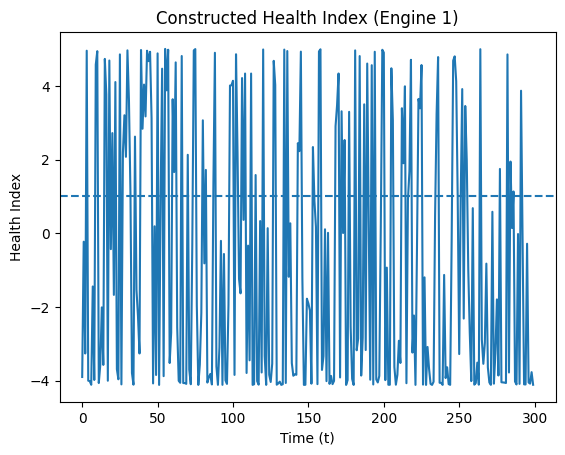

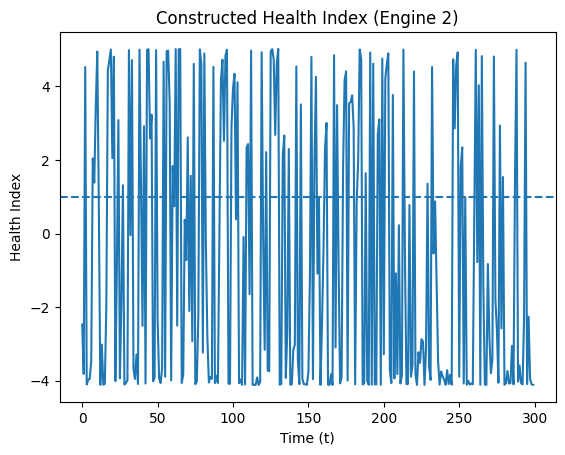

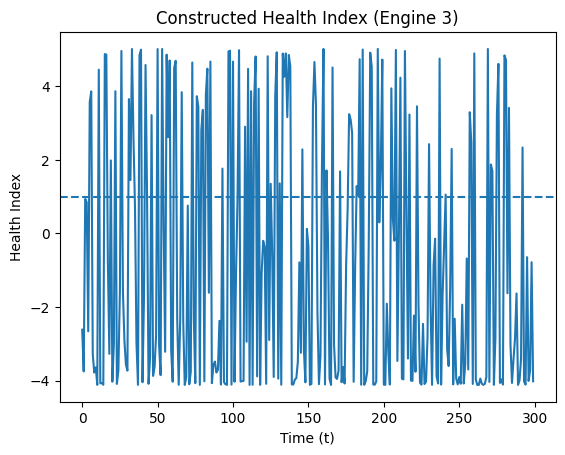

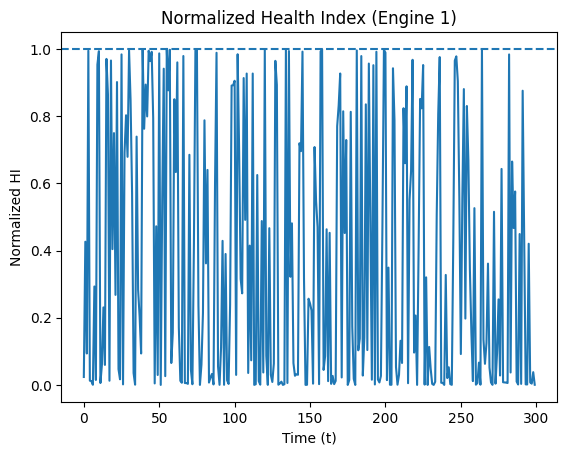

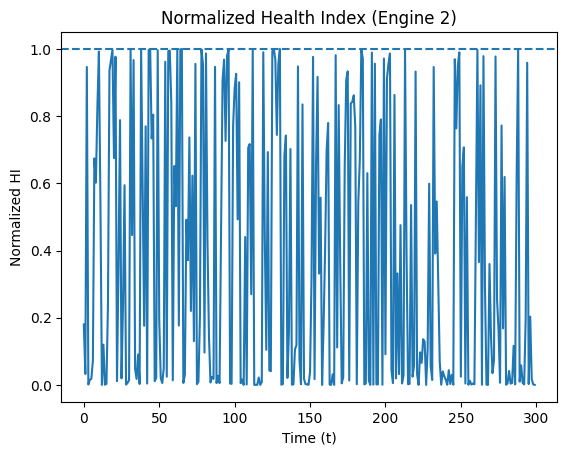

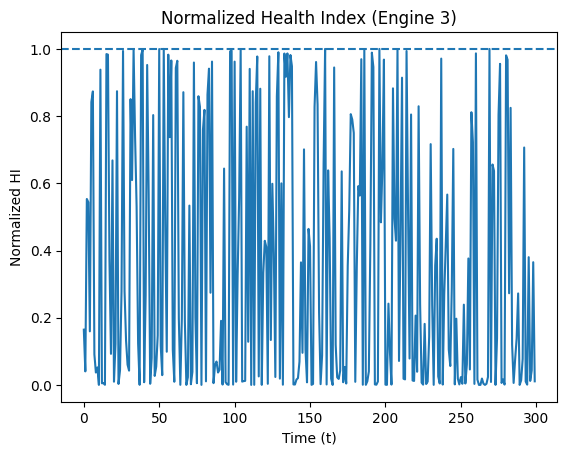

In [126]:
net.eval()
with torch.no_grad():
    h_all = net(X_tensor).cpu().numpy()   # shape: (900,)

import matplotlib.pyplot as plt
import numpy as np

for e in range(num_engines):
    s = e * K
    e_idx = (e + 1) * K

    h_e = h_all[s:e_idx]
    t = np.arange(K)

    plt.figure()
    plt.plot(t, h_e)
    plt.xlabel("Time (t)")
    plt.ylabel("Health Index")
    plt.title(f"Constructed Health Index (Engine {e+1})")
    plt.axhline(1.0, linestyle="--")   # failure threshold
    plt.show()

for e in range(num_engines):
    s = e * K
    e_idx = (e + 1) * K

    h_e = h_all[s:e_idx]
    h_norm = (h_e - h_e.min()) / (h_e.max() - h_e.min() + 1e-8)
    t = np.arange(K)

    plt.figure()
    plt.plot(t, h_norm)
    plt.xlabel("Time (t)")
    plt.ylabel("Normalized HI")
    plt.title(f"Normalized Health Index (Engine {e+1})")
    plt.axhline(1.0, linestyle="--")
    plt.show()
